# Modelling with neural network

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# The tensorflow code here is compatible with tensorflow 1.13 and 2, but SHAP is not yet tf2 compatible
#!pip install tensorflow==2.0.0-alpha0
#!pip install tensorflow

## Load data

In [3]:
#dfe = pd.read_csv('../input/jobcloud-embeddings-multilingual-clean/sentence_embeddings_multilingual_clean.csv', index_col=0)
dfe = pd.read_csv('Embeddings/sentence_embeddings_en_clean.csv', index_col=0)
#dfe = pd.read_csv('../input/sentence-embeddings-en/sentence_embeddings_en.csv', index_col=0)
dfe.shape

(101735, 768)

In [4]:
df = pd.read_csv('Data/jobcloud_features_v2.csv', delimiter = ';', parse_dates = ['start_dt', 'end_dt'])
df.shape

(101735, 31)

In [5]:
df = pd.concat([df, dfe], axis = 1)
df.shape

(101735, 799)

## Predict 10-day view count

In [6]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [7]:
DAYS = 10
y_col = '%sd_view_cnt' % DAYS

# Select jobs ads which have been online long enough and remove view count outliers
#df = df.loc[df['days_online'] >= DAYS] # (62646, 31)
df = df.loc[(df['days_online'] >= DAYS) & (df[y_col] <= 7.0)]
df.shape

(62623, 799)

In [8]:
features = ['contract_pct_from', 'contract_pct_to', 'month', 'package_id', 'industry_name',# 'days_online', 
            'city', 'title_num_words', 'title_aggressive', 'title_female', 'title_percent',
            'title_location', 'title_diploma', 'title_chief', 'title_prob_en',
            'title_prob_de', 'title_prob_fr']
X = pd.get_dummies(df.loc[:, features + list(dfe.columns)], columns=['package_id', 'city', 'industry_name', 'month'])
y = df[y_col]
X.shape

(62623, 829)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((41957, 829), (20666, 829), (41957,), (20666,))

In [10]:
def make_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(X.shape[1], )),
        tf.keras.layers.Dense(200, activation=tf.nn.relu),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])
    return model

model = make_model()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [11]:
# After 3 epochs, validation loss seems to reach a minimum and increases with more epochs. Therefore, we use only 3 epochs to prevent overfitting.
EPOCHS = 3

# Save model weights so we can reuse them.
cp_callback = tf.keras.callbacks.ModelCheckpoint('Model/', save_weights_only=True, save_best_only=True, verbose=1)
history = model.fit(X_train, y_train, epochs=EPOCHS, verbose=1, validation_split=0.2, callbacks=[cp_callback])

Train on 33565 samples, validate on 8392 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/3
33248/33565 [============================>.] - ETA: 0s - loss: 2.6753 - mean_squared_error: 2.6753
Epoch 00001: val_loss improved from inf to 0.31395, saving model to Model/

Consider using a TensorFlow optimizer from `tf.train`.
Instructions for updating:
Use tf.train.CheckpointManager to manage checkpoints rather than manually editing the Checkpoint proto.
33565/33565 [==============================] - 7s 195us/sample - loss: 2.6535 - mean_squared_error: 2.6535 - val_loss: 0.3139 - val_mean_squared_error: 0.3139
Epoch 2/3
33376/33565 [============================>.] - ETA: 0s - loss: 0.3150 - mean_squared_error: 0.3150
Epoch 00002: val_loss improved from 0.31395 to 0.28182, saving model to Model/

Consider using a TensorFlow optimizer from `tf.train`.
33565/33565 [==============================] - 6s 185us/sample - loss: 0.3147 - mean_squared_error: 0.3147 - val_loss: 0.2818 - v

In [12]:
model.evaluate(X_test, y_test)

20666/20666 [==============================] - 1s 59us/sample - loss: 0.2887 - mean_squared_error: 0.2887


[0.28874328556555023, 0.28874326]

In [13]:
y_pred = model.predict(X_test)
r2_score(y_test, y_pred)

0.32236359301104645

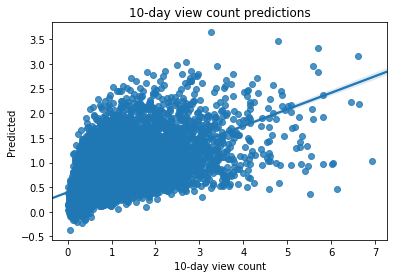

In [14]:
sns.regplot(y_test, y_pred.flatten())
plt.xlabel('10-day view count')
plt.ylabel('Predicted')
plt.title('10-day view count predictions')
plt.show()

## Crossfold validation

In [15]:
from sklearn.model_selection import KFold

def crossfold_validation(X: pd.DataFrame, y: pd.Series, n_splits=4) -> list:
    cv_scores = []
    kf = KFold(n_splits=n_splits, random_state=42)
    for train_index, test_index in kf.split(X.values):
        X_train, X_test = X.values[train_index], X.values[test_index]
        y_train, y_test = y.values[train_index], y.values[test_index]
        model = make_model()
        history = model.fit(X_train, y_train, epochs=EPOCHS, verbose=1, validation_split=0.2)
        cv_score = r2_score(y_test, model.predict(X_test))
        print('R2 score: %.3f\n' % cv_score)
        cv_scores.append(cv_score)

    return cv_scores

crossfold_validation(X, y)

Train on 37573 samples, validate on 9394 samples
Epoch 1/3
37573/37573 [==============================] - 6s 152us/sample - loss: 1.3728 - mean_squared_error: 1.3728 - val_loss: 0.3931 - val_mean_squared_error: 0.3931
Epoch 2/3
37573/37573 [==============================] - 5s 142us/sample - loss: 0.2954 - mean_squared_error: 0.2954 - val_loss: 0.3700 - val_mean_squared_error: 0.3700
Epoch 3/3
37573/37573 [==============================] - 5s 142us/sample - loss: 0.2789 - mean_squared_error: 0.2789 - val_loss: 0.3719 - val_mean_squared_error: 0.3719
R2 score: 0.350

Train on 37573 samples, validate on 9394 samples
Epoch 1/3
37573/37573 [==============================] - 6s 160us/sample - loss: 0.7295 - mean_squared_error: 0.7295 - val_loss: 0.3868 - val_mean_squared_error: 0.3868
Epoch 2/3
37573/37573 [==============================] - 5s 140us/sample - loss: 0.2754 - mean_squared_error: 0.2754 - val_loss: 0.4310 - val_mean_squared_error: 0.4310
Epoch 3/3
37573/37573 [=================

[0.3500073834666635,
 0.3859258554306978,
 0.3851772185017508,
 0.2510276710414845]

## Explainability (SHAP)

In [16]:
#!pip install -U shap
import shap

### Individual predictions

In [17]:
# Calculate shap values
NUM_BACKGROUND_SAMPLES = 500

# Select a set of background examples to take an expectation over
# See https://github.com/slundberg/shap/blob/master/notebooks/deep_explainer/Front%20Page%20DeepExplainer%20MNIST%20Example.ipynb
background_train = X_train.sample(NUM_BACKGROUND_SAMPLES, random_state=42)
explainer = shap.DeepExplainer(model, background_train)
shap_values_test = explainer.shap_values(X_test.values[0:50])

# The tensorflow model outputs predictions as a list of lists with one element. This seems to be reflected
# in the shap_values which are given as a list with one element. We therefore unpack the shap_values
shap_values_test = shap_values_test[0]
shap_values_test.shape

(50, 829)

Exampe 3, model prediction: 0.234


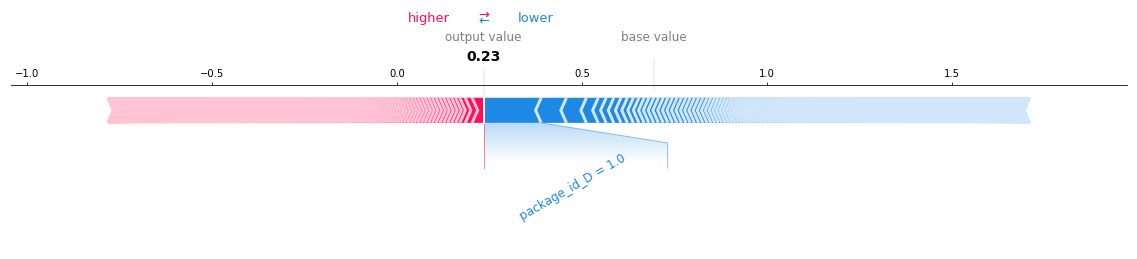

Exampe 5, model prediction: 1.773


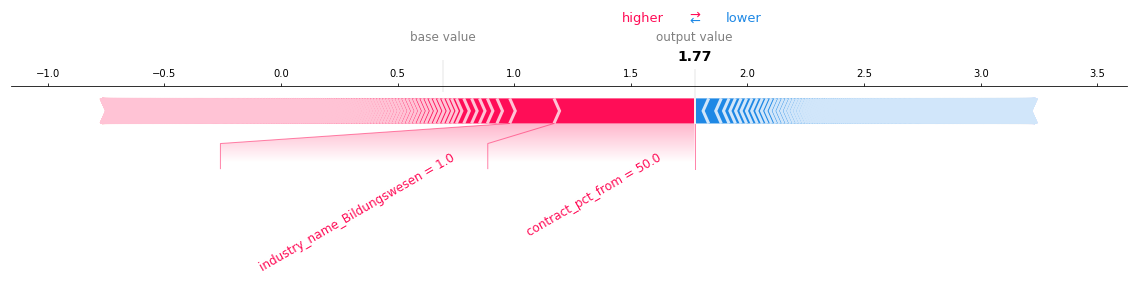

Exampe 11, model prediction: 0.735


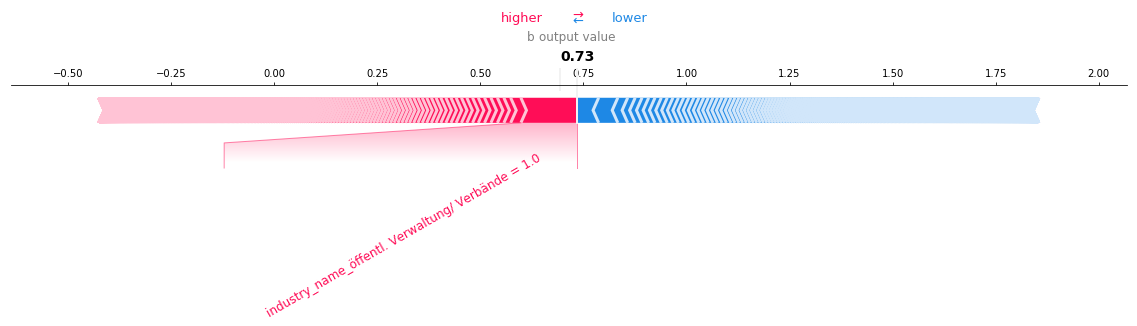

Exampe 19, model prediction: 0.628


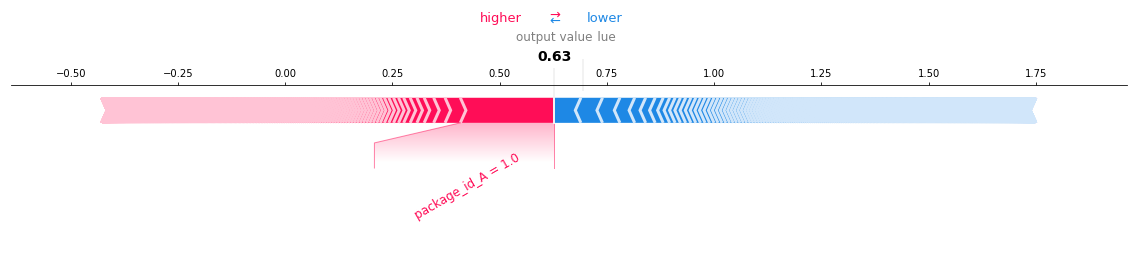

Exampe 37, model prediction: 0.366


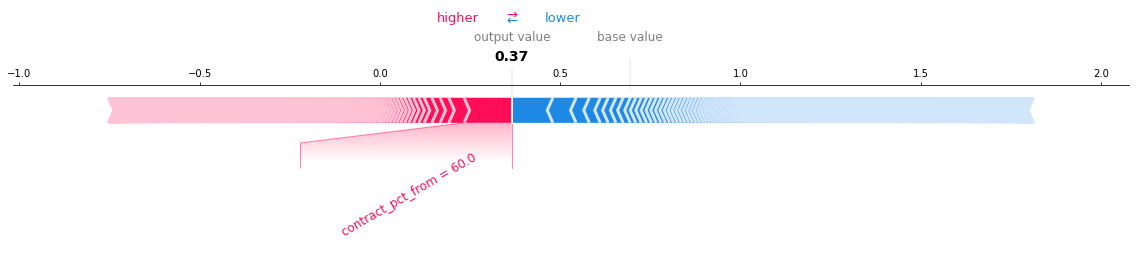

In [18]:
shap.initjs()

selected_plots = [3, 5, 11, 19, 37] # Selected plots with interesting insights
for i in selected_plots:
    print('Exampe %d, model prediction: %.3f' % (i, model.predict(X_test.iloc[[i]])[0]))
    # text_rotation does not work with the interactive shap plots. It works if matplotlib=True is specified.
    #display(shap.force_plot(explainer.expected_value, shap_values[i], np.round(X_test.iloc[i, :], 3), text_rotation=90))
    shap.force_plot(explainer.expected_value, shap_values_test[i], np.round(X_test.iloc[i, :], 3), text_rotation=30, matplotlib=True)

### Summary plots

In [40]:
NUM_SUMMARY_SAMPLES = 1000

summary_samples = X_train.sample(NUM_SUMMARY_SAMPLES, random_state=42)
shap_values_summary = explainer.shap_values(summary_samples.values)[0]

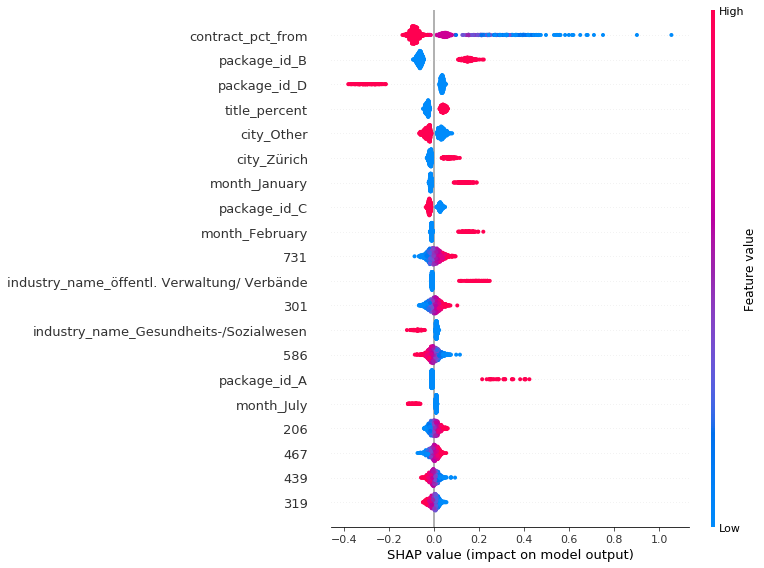

In [41]:
shap.summary_plot(shap_values_summary, features=summary_samples, feature_names=X.columns, max_display=20)

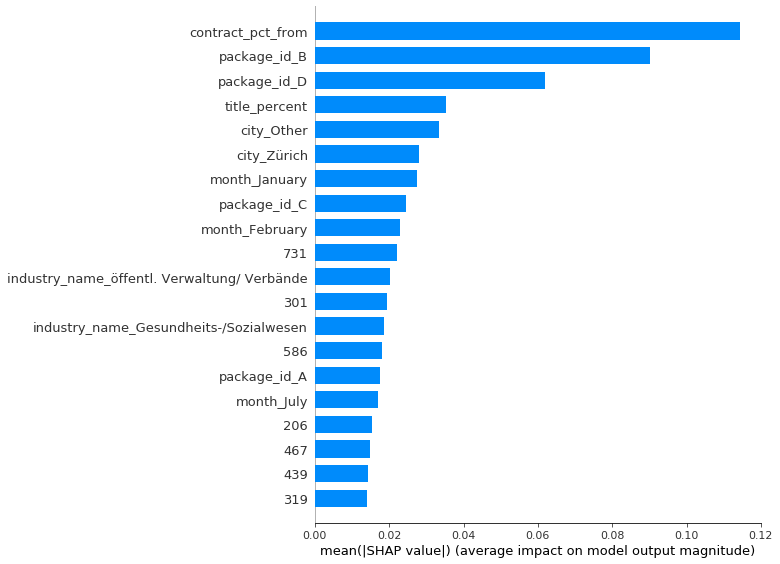

In [42]:
shap.summary_plot(shap_values_summary, features=summary_samples, feature_names=X.columns, max_display=20, plot_type='bar')

In [43]:
# The interactive summary force plot slows the notebook down and does not reveal anything interesting, it seems 
#shap.force_plot(explainer.expected_value, shap_values_summary, features=summary_samples, feature_names=X.columns)

## Probabilitstic model with confidence intervals
See https://medium.com/tensorflow/regression-with-probabilistic-layers-in-tensorflow-probability-e46ff5d37baf

In [44]:
import tensorflow_probability as tfp
tfd = tfp.distributions

negloglik = lambda y, p_y: -p_y.log_prob(y)

model_prob = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(X.shape[1], )),
    tf.keras.layers.Dense(200, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.2),
    #tf.keras.layers.Dense(1)
    tf.keras.layers.Dense(1 + 1),
    tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t[..., :1], scale=1e-3 + tf.math.softplus(0.05 * t[..., 1:]))),
])

# Do inference.
#model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.05), loss=negloglik)
model_prob.compile(optimizer='adam', loss=negloglik)
history = model_prob.fit(X_train, y_train, epochs=EPOCHS, verbose=1, validation_split=0.2)


ModuleNotFoundError: No module named 'tensorflow_probability'

In [ ]:
# Make predictions. => Not working...
#y_pred = model_prob.predict(X_test)
#r2_score(y_test, y_pred)